In [1]:
#Install imblearn
# !pip install imblearn

In [2]:
#conda install -c glemaitre imbalanced-learn

In [3]:
#pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.linear_model import SGDClassifier,LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

from sklearn.utils import resample, shuffle
# const random_state 
RANDOM_STATE = 12345

## Download the data

In [5]:
#Read csv files
contract = pd.read_csv('/datasets/final_provider/contract.csv') 
personal = pd.read_csv('/datasets/final_provider/personal.csv') 
internet = pd.read_csv('/datasets/final_provider/internet.csv') 
phone = pd.read_csv('/datasets/final_provider/phone.csv') 

## Preprocess the data

### Preprocess contract file

In [6]:

contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
14,5129-JLPIS,2018-01-01,No,Month-to-month,Yes,Electronic check,105.50,2686.05
454,4785-FCIFB,2015-01-01,No,Two year,No,Mailed check,24.40,1417.9
2347,7089-RKVSZ,2019-06-01,No,One year,No,Mailed check,24.40,203.95
6738,3590-TCXTB,2020-01-01,No,Month-to-month,No,Mailed check,20.35,20.35
4000,0420-HLGXF,2016-11-01,No,Month-to-month,Yes,Electronic check,99.75,4036
2924,1428-GTBJJ,2018-12-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,74.55,824.75
1516,6198-RTPMF,2018-09-01,No,Month-to-month,No,Electronic check,92.60,1579.7
2598,8325-QRPZR,2019-07-01,No,Month-to-month,Yes,Electronic check,75.15,525
4442,9837-BMCLM,2019-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,78.50,242.05
341,6885-PKOAM,2014-03-01,No,Two year,No,Credit card (automatic),85.75,6223.8


In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
# Check for null values
contract.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [9]:
# Check date borders
print(f'BeginDate min date: {contract["BeginDate"].min()}')
print(f'BeginDate max date: {contract["BeginDate"].max()}')


BeginDate min date: 2013-10-01
BeginDate max date: 2020-02-01


The borders dates are normal, no future dates(beyond 2020-02-01) or unreasonable dates

In [10]:
#Get unique 'Type' values
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [11]:
#Get unique 'PaperlessBilling' values
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [12]:
#Get unique 'PaymentMethod' values
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [13]:
#Ckeck borders
#Check min value for validation(not negative or a very small amount)
print(f'MonthlyCharges min value: {contract["MonthlyCharges"].min()}')
print(f'MonthlyCharges max value: {contract["MonthlyCharges"].max()}')


MonthlyCharges min value: 18.25
MonthlyCharges max value: 118.75


In [14]:
#Check for duplicated data
contract.duplicated().sum()

0

In [15]:
contract['TotalCharges'].value_counts()

           11
20.2       11
19.75       9
20.05       8
19.9        8
           ..
1316.9      1
3375.9      1
3877.95     1
1275.7      1
2344.5      1
Name: TotalCharges, Length: 6531, dtype: int64

There are 11 observations with empty value.
i'll explorer them

In [16]:
# Users that subscribe less than a month, the 'TotalCharges' is empty
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


 Users that subscribe less than a month, the 'TotalCharges' is empty.  
 They are not been charged yet.  
 for those users, change 'TotalCharges' from empty value to 0.  

In [17]:
# For users that subscribed less than a month, change 'TotalCharges' from empty value to 0.
contract.loc[contract['TotalCharges'] == ' ','TotalCharges'] = 0

In [18]:
# For users that left, Add new feature 'subscriptionAge'  as 'EndDate' - 'BeginDate'
contract.loc[contract['EndDate'] != 'No','subscriptionAge'] = \
                                                 pd.to_datetime(contract.loc[contract['EndDate'] != 'No','EndDate']) - \
                                                 pd.to_datetime(contract.loc[contract['EndDate'] != 'No','BeginDate'])


In [19]:
# For existing users , Add new feature 'subscriptionAge'  as '2020-02-01' - 'BeginDate'
contract.loc[contract['EndDate'] == 'No','subscriptionAge'] = \
                                                 pd.to_datetime('2020-02-01') - \
                                                 pd.to_datetime(contract.loc[contract['EndDate'] == 'No','BeginDate'])


 -  For users that left, Add new feature 'subscriptionAge'  as 'EndDate' - 'BeginDate'
 -  For existing users , Add new feature 'subscriptionAge'  as '2020-02-01' - 'BeginDate'
 - The contract information is valid as of '2020-02-01', as mention in the description.

In [20]:
# Replace Yes to 1 and No to 0
contract.PaperlessBilling= contract.PaperlessBilling.map(dict(Yes=1, No=0))
contract.loc[contract['EndDate'] != 'No','EndDate'] = 0
contract.loc[contract['EndDate'] == 'No','EndDate'] = 1
#contract.EndDate= contract.EndDate.map(dict( No=1))

In [21]:
#Check that replacment was made currectly
contract['EndDate'].unique()

array([1, 0])

In [22]:
#Data type replacment
contract['TotalCharges'] = contract['TotalCharges'].astype(float)
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['PaperlessBilling'] = contract['PaperlessBilling'].astype(np.int8)

# convert timedelta64 ns to int
contract['subscriptionAge'] = contract['subscriptionAge'].dt.days
# Convert int64 to int32 - int32 is enough for this feature
contract['subscriptionAge'] = contract['subscriptionAge'].astype(np.int32)
contract['EndDate'] = contract['EndDate'].astype(np.int8)


In [23]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null int8
Type                7043 non-null object
PaperlessBilling    7043 non-null int8
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
subscriptionAge     7043 non-null int32
dtypes: datetime64[ns](1), float64(2), int32(1), int8(2), object(3)
memory usage: 371.5+ KB


In [24]:
contract.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscriptionAge
6929,0357-NVCRI,2018-01-01,1,Month-to-month,0,Credit card (automatic),20.05,471.70,761
5681,2522-WLNSF,2017-04-01,1,One year,0,Bank transfer (automatic),64.20,2106.30,1036
3910,8938-UMKPI,2015-11-01,0,Month-to-month,1,Electronic check,106.40,5127.95,1430
313,2799-ARNLO,2019-09-01,1,Month-to-month,1,Electronic check,69.35,341.60,153
3573,6506-EYCNH,2017-10-01,1,Month-to-month,1,Bank transfer (automatic),19.55,543.80,853
2592,3750-RNQKR,2019-02-01,1,Month-to-month,0,Mailed check,19.45,246.25,365
3063,1666-JXLKU,2017-01-01,1,Month-to-month,1,Electronic check,100.05,3810.55,1126
996,6641-XRPSU,2017-03-01,0,Month-to-month,1,Credit card (automatic),70.00,2416.10,1036
3909,1093-YSWCA,2019-03-01,1,Two year,0,Credit card (automatic),19.55,223.15,337
1527,0640-YJTPY,2014-02-01,1,Two year,0,Bank transfer (automatic),21.00,1493.75,2191


**Conclusion**
- There are no null's in the data.
- Add new feature 'subscriptionAge' - how long the user is subscribe 
- Users that subscribe less than a month, the 'TotalCharges' is empty.  
     They are not been charged yet.  
     for those users, change 'TotalCharges' from empty value to 0.  
- Data type replacment was made.
- There is no duplicated data

### Preprocess personal file

In [25]:
personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
5517,7472-EQOAV,Male,1,Yes,Yes
6835,7964-ZRKKG,Male,0,Yes,No
3810,2903-YYTBW,Male,0,Yes,Yes
2577,4910-GMJOT,Female,0,No,No
3971,8515-OCTJS,Female,0,No,No
5210,2794-XIMMO,Male,0,Yes,No
964,9117-SHLZX,Male,0,No,No
3189,5384-ZTTWP,Female,0,Yes,Yes
1707,4854-CIDCF,Female,1,No,No
3968,7463-IFMQU,Female,0,Yes,No


In [26]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [27]:
# Check for null values
personal.isnull().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [28]:
#Get unique 'gender' values
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [29]:
#Get unique 'SeniorCitizen' values
personal['SeniorCitizen'].unique()

array([0, 1])

In [30]:
#Get unique 'Partner' values
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [31]:
#Get unique 'Dependents' values
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [32]:
# Replace Yes to 1 and No to 0
personal.Partner= personal.Partner.map(dict(Yes=1, No=0))
personal.Dependents= personal.Dependents.map(dict(Yes=1, No=0))

In [33]:
# Data type replacment
personal.Partner = personal.Partner.astype(np.int8)
personal.SeniorCitizen = personal.SeniorCitizen.astype(np.int8)
personal.Dependents = personal.Dependents.astype(np.int8)

In [34]:
#DOTO:
#change gender

In [35]:
#Check for duplicated data
personal.duplicated().sum()

0

In [36]:
personal.sample(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
4056,3329-WDIOK,Female,0,0,0
5511,6586-MYGKD,Male,0,1,0
4612,6723-CEGQI,Female,0,0,1
6469,7945-PRBVF,Male,0,0,0
5931,0011-IGKFF,Male,1,1,0
4840,5730-RIITO,Female,1,0,0
1729,8226-BXGES,Male,0,1,0
285,6202-DYYFX,Female,0,0,0
737,2521-NPUZR,Male,0,1,0
417,5249-QYHEX,Female,0,1,1


**Conclusion**
- There are no null's in the data.
- Data type replacment was made.
- There is no duplicated data.

### Preprocess internet file

In [37]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3656,0345-XMMUG,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
1458,6702-OHFWR,DSL,No,Yes,Yes,No,No,Yes
4612,0856-NAOES,DSL,No,No,Yes,No,Yes,No
553,0067-DKWBL,DSL,Yes,No,No,No,No,No
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
3600,6723-CEGQI,DSL,No,Yes,No,Yes,Yes,No
2988,8819-ZBYNA,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
930,1282-IHQAC,DSL,No,Yes,Yes,No,Yes,No
4515,1415-YFWLT,Fiber optic,No,No,No,No,Yes,Yes
5470,1684-FLBGS,DSL,No,Yes,No,Yes,Yes,No


In [38]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [39]:
# Check for null values
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [40]:
#Get unique  values
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [41]:
#Get unique values
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [42]:
#Get unique  values
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [43]:
#Get unique  values
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [44]:
#Get unique  values
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [45]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [46]:
#TODO:
#InternetService

In [47]:
# Replace Yes to 1 and No to 0
internet.OnlineSecurity= internet.OnlineSecurity.map(dict(Yes=1, No=0))
internet.OnlineBackup= internet.OnlineBackup.map(dict(Yes=1, No=0))
internet.DeviceProtection= internet.DeviceProtection.map(dict(Yes=1, No=0))
internet.TechSupport= internet.TechSupport.map(dict(Yes=1, No=0))
internet.StreamingTV= internet.StreamingTV.map(dict(Yes=1, No=0))
internet.StreamingMovies= internet.StreamingMovies.map(dict(Yes=1, No=0))

In [48]:
# Replace data types 
internet.OnlineSecurity = internet.OnlineSecurity.astype(np.int8)
internet.OnlineBackup = internet.OnlineBackup.astype(np.int8)
internet.DeviceProtection = internet.DeviceProtection.astype(np.int8)
internet.TechSupport = internet.TechSupport.astype(np.int8)
internet.StreamingTV = internet.StreamingTV.astype(np.int8)
internet.StreamingMovies = internet.StreamingMovies.astype(np.int8)

In [49]:
#Check for duplicated data
internet.duplicated().sum()

0

In [50]:
internet.sample(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2835,6479-VDGRK,DSL,1,1,1,1,1,1
1651,8087-LGYHQ,Fiber optic,0,0,1,0,1,1
3299,8107-KNCIM,Fiber optic,0,0,0,0,0,0
2007,5843-TTHGI,DSL,0,0,1,0,0,0
3352,2789-CZANW,Fiber optic,1,1,0,1,1,1
3191,0946-CLJTI,Fiber optic,0,0,1,0,1,1
4987,4000-VGMQP,DSL,0,1,1,0,1,1
3708,5729-KLZAR,Fiber optic,0,0,0,0,0,1
4933,0691-NIKRI,Fiber optic,0,0,1,1,1,1
4993,7994-XIRTR,DSL,0,0,1,1,0,1


**Conclusion**
- There are no null's in the data.
- Data type replacment was made.
- There is no duplicated data

### Preprocess phone file

In [51]:
phone.sample(10)

,customerID,MultipleLines
4015,3059-NGMXB,Yes
6359,8361-LTMKD,Yes
864,9448-REEVD,No
1298,4652-ODEVH,Yes
140,9167-APMXZ,Yes
3557,2139-FQHLM,No
3611,7463-IFMQU,No
5879,9548-LERKT,No
3357,1150-WFARN,Yes
4574,4092-OFQZS,No


In [52]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [53]:
# Check for null values
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

In [54]:
#Get unique values
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

In [55]:
#Check for duplicated data
phone.duplicated().sum()

0

In [56]:
# Replace Yes to 1 and No to 0
#phone.MultipleLines= phone.MultipleLines.map(dict(Yes=1, No=0))

In [57]:
# Replace data type
#phone.MultipleLines= phone.MultipleLines.astype(np.int8)

In [58]:
phone.sample(10)

,customerID,MultipleLines
6286,2451-YMUXS,Yes
5712,5442-BHQNG,No
3169,2921-XWDJH,No
2786,1666-JXLKU,Yes
3896,3740-RLMVT,No
1248,1839-FBNFR,No
5356,6172-FECYY,Yes
4821,1213-NGCUN,No
1148,6818-WOBHJ,Yes
5422,0780-XNZFN,No


**Conclusion**
- There are no null's in the data.
- Data type replacment was made. #TODO:delete this 
- There is no duplicated data

## EDA

### Merge tables

In [59]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null int8
OnlineBackup        5517 non-null int8
DeviceProtection    5517 non-null int8
TechSupport         5517 non-null int8
StreamingTV         5517 non-null int8
StreamingMovies     5517 non-null int8
dtypes: int8(6), object(2)
memory usage: 118.7+ KB


In [60]:
# Merge all dataFrames into one dataFrame
users = contract.merge(personal,on='customerID', how='left').merge(internet,on='customerID', how='left')\
        .merge(phone,on='customerID', how='left')

In [61]:
users.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscriptionAge,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5491,3703-TTEPD,2018-05-01,1,Month-to-month,0,Bank transfer (automatic),65.35,1424.40,641,Male,...,0,0,DSL,1.0,0.0,1.0,0.0,1.0,0.0,No
3492,0975-VOOVL,2019-11-01,1,Month-to-month,0,Mailed check,29.20,98.50,92,Female,...,0,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
184,1918-ZBFQJ,2018-09-01,0,Month-to-month,1,Electronic check,79.25,1111.65,395,Female,...,0,0,Fiber optic,0.0,1.0,1.0,0.0,0.0,0.0,No
6689,8561-NMTBD,2014-07-01,1,One year,1,Credit card (automatic),112.35,7388.45,2041,Female,...,1,1,Fiber optic,0.0,1.0,1.0,1.0,1.0,1.0,Yes
5372,2786-GCDPI,2015-12-01,1,Month-to-month,1,Electronic check,104.95,5222.35,1523,Female,...,0,0,Fiber optic,0.0,0.0,1.0,1.0,1.0,1.0,Yes
6776,6120-RJKLU,2014-12-01,1,Two year,1,Credit card (automatic),79.95,4819.75,1888,Female,...,1,0,DSL,1.0,0.0,1.0,1.0,1.0,1.0,No
2001,3977-QCRSL,2019-09-01,1,Month-to-month,0,Mailed check,20.15,117.95,153,Female,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4900,7137-RYLPP,2016-12-01,0,Month-to-month,1,Electronic check,85.70,3171.15,1126,Male,...,1,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,Yes
4634,9426-SXNHE,2019-12-01,1,Month-to-month,0,Bank transfer (automatic),18.75,53.15,62,Female,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5206,7349-ALMUX,2017-01-01,1,Two year,0,Bank transfer (automatic),65.60,2313.80,1126,Male,...,0,0,DSL,1.0,1.0,1.0,1.0,0.0,0.0,No


In [62]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null int8
Type                7043 non-null object
PaperlessBilling    7043 non-null int8
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
subscriptionAge     7043 non-null int32
gender              7043 non-null object
SeniorCitizen       7043 non-null int8
Partner             7043 non-null int8
Dependents          7043 non-null int8
InternetService     5517 non-null object
OnlineSecurity      5517 non-null float64
OnlineBackup        5517 non-null float64
DeviceProtection    5517 non-null float64
TechSupport         5517 non-null float64
StreamingTV         5517 non-null float64
StreamingMovies     5517 non-null float64
MultipleLines       6361 non-null object
dtypes: datetime64[ns](1), 

After the merge the data types of the following features was changed from int to float.
- 'OnlineSecurity'
- 'OnlineBackup'
- 'DeviceProtection'
- 'TechSupport'
- 'StreamingTV'
- 'StreamingMovies'  

This happens because after the merge, there are null values in those features, so pandas converted them to float.

This bug was fixed in pandas [v0.19.0](https://pandas.pydata.org/docs/whatsnew/v0.19.0.html#merging-changes)

In [63]:
users.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
subscriptionAge        0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [64]:
# Check if there are users without a phone line and internet services
users.query('MultipleLines.isnull() & InternetService.isnull() ')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscriptionAge,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines


In [65]:
# Users that have only one of the services
users.query('MultipleLines.isnull() | InternetService.isnull() ')[['MultipleLines','InternetService']]

,MultipleLines,InternetService
0,NaN,DSL
3,NaN,DSL
7,NaN,DSL
11,No,NaN
16,No,NaN
...,...,...
7029,NaN,DSL
7030,No,NaN
7036,NaN,DSL
7037,No,NaN


In [66]:
# Fill missing values.
# we can conclude that users with null are not subscribe to any additional services
# Fill with value 0 
services = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
users[services] = users[services].fillna(0)

In [67]:
# users that are not subscribe to one of this services, change null to 'Not subscribe'
#it is possible that users don't have one of this services
users[['InternetService','MultipleLines']] = users[['InternetService','MultipleLines']].fillna('Not subscribe')

In [68]:
#Check if there are still null values 
users.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
subscriptionAge     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

### Check for outliers

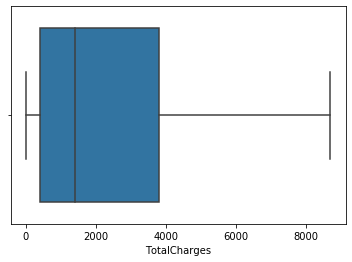

In [69]:
#Check for outliers in 'TotalCharges'
sns.boxplot(x=users['TotalCharges'])


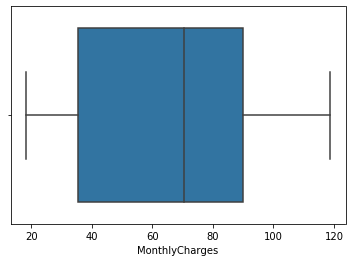

In [70]:
#Check for outliers in 'MonthlyCharges'
sns.boxplot(x=users['MonthlyCharges'])

There are no outliers in the data

### Plot graph's

#### Distribution of 'Type' for former users

In [71]:
former_users = users.query("EndDate == 1")
former_users.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscriptionAge,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6974,0422-UXFAP,2015-11-01,1,One year,1,Electronic check,98.85,4947.55,1553,Female,...,1,0,Fiber optic,0.0,0.0,1.0,0.0,1.0,1.0,Yes
2522,0661-KBKPA,2015-09-01,1,One year,1,Mailed check,78.75,3942.45,1614,Male,...,1,1,DSL,0.0,0.0,1.0,1.0,1.0,1.0,Yes
6870,3452-SRFEG,2016-01-01,1,Month-to-month,1,Bank transfer (automatic),74.60,3720.35,1492,Male,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4249,7919-ZODZZ,2019-04-01,1,One year,1,Mailed check,65.90,660.05,306,Female,...,1,1,DSL,0.0,1.0,1.0,0.0,0.0,1.0,No
4319,6333-YDVLT,2014-09-01,1,One year,1,Credit card (automatic),110.00,7138.65,1979,Male,...,0,0,Fiber optic,1.0,0.0,1.0,1.0,1.0,1.0,Yes
1914,5356-CSVSQ,2019-11-01,1,Month-to-month,0,Electronic check,64.60,174.20,92,Female,...,0,0,DSL,0.0,0.0,0.0,1.0,1.0,0.0,Yes
3474,3982-DQLUS,2014-09-01,1,Month-to-month,1,Electronic check,85.75,5688.45,1979,Male,...,1,1,Fiber optic,1.0,1.0,0.0,0.0,0.0,0.0,Yes
1813,0817-HSUSE,2020-01-01,1,Month-to-month,1,Electronic check,75.50,75.50,31,Male,...,0,0,DSL,0.0,0.0,1.0,1.0,1.0,1.0,No
1553,7776-QGYJC,2016-11-01,1,Month-to-month,1,Bank transfer (automatic),81.50,3107.30,1187,Female,...,1,1,Fiber optic,0.0,0.0,1.0,1.0,0.0,0.0,No
5488,7856-GANIL,2016-05-01,1,One year,1,Bank transfer (automatic),98.70,4525.80,1371,Male,...,1,0,Fiber optic,0.0,1.0,1.0,1.0,1.0,0.0,Yes


In [72]:
# Get number of former customers for each 'Type'
formerUsers_byType = former_users.pivot_table(index='Type',
                                       values='customerID',
                                       aggfunc='count'
                                      )
formerUsers_byType

,customerID
Type,
Month-to-month,2220
One year,1307
Two year,1647


Text(0.5, 1.0, 'Number of former users by plan type ')

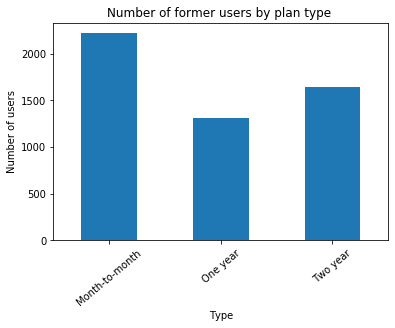

In [73]:
formerUsers_byType.plot(kind='bar',rot=40, legend=None);
plt.xlabel('Type')
plt.ylabel('Number of users')
plt.title('Number of former users by plan type ')

The majority of former users had a 'Month-to-month' program

#### Distribution of 'Type' for existing users

In [74]:
existing_users = users.query("EndDate == 0")
existing_users.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,subscriptionAge,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2262,4529-CKBCL,2019-11-01,0,Month-to-month,1,Electronic check,80.20,146.05,61,Female,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,No
3004,3801-HMYNL,2019-10-01,0,Month-to-month,0,Mailed check,89.15,89.15,31,Male,...,1,1,Fiber optic,0.0,0.0,0.0,0.0,1.0,1.0,No
5497,7614-QVWQL,2015-09-01,0,One year,1,Bank transfer (automatic),51.80,2541.25,1491,Male,...,1,1,DSL,0.0,1.0,0.0,0.0,1.0,1.0,Not subscribe
834,9231-ZJYAM,2019-07-01,0,Month-to-month,1,Electronic check,78.85,292.80,123,Female,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,1.0,0.0,No
5722,3096-JRDSO,2017-09-01,0,Month-to-month,1,Bank transfer (automatic),104.30,2867.75,821,Female,...,1,0,Fiber optic,1.0,0.0,0.0,1.0,1.0,1.0,Yes
5615,1493-AMTIE,2019-10-01,0,Month-to-month,1,Bank transfer (automatic),20.20,20.20,31,Male,...,0,0,Not subscribe,0.0,0.0,0.0,0.0,0.0,0.0,No
354,0623-IIHUG,2018-04-01,0,Month-to-month,1,Electronic check,41.90,840.10,640,Female,...,0,0,DSL,1.0,0.0,0.0,0.0,1.0,0.0,Not subscribe
2070,8624-GIOUT,2015-10-01,0,Month-to-month,1,Credit card (automatic),59.75,2934.30,1492,Female,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,Yes
3332,7593-XFKDI,2019-11-01,0,Month-to-month,0,Mailed check,46.30,46.30,30,Male,...,0,0,DSL,0.0,0.0,0.0,0.0,0.0,0.0,No
3197,3523-QRQLL,2017-12-01,0,One year,1,Bank transfer (automatic),69.50,1498.20,669,Female,...,1,1,DSL,0.0,1.0,0.0,0.0,1.0,1.0,No


In [75]:
#Get number of existing customers for each 'Type'
existingUsers_byType = existing_users.pivot_table(index='Type',
                                       values='customerID',
                                       aggfunc='count'
                                      )
# Calculate the percentage for each type
existingUsers_byType['percentage'] = \
                (existingUsers_byType.customerID / existingUsers_byType.customerID.sum() * 100 ).map("{:,.2f}%".format)
existingUsers_byType

,customerID,percentage
Type,,
Month-to-month,1655,88.55%
One year,166,8.88%
Two year,48,2.57%


Text(0.5, 1.0, 'Number of existing users by plan type ')

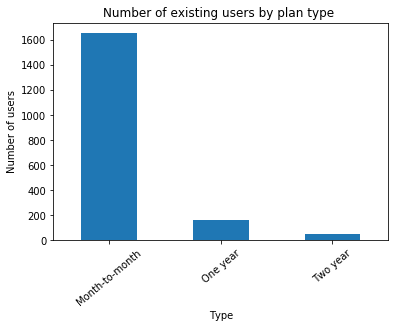

In [76]:
existingUsers_byType.plot(kind='bar',rot=40, legend=None);
plt.xlabel('Type')
plt.ylabel('Number of users')
plt.title('Number of existing users by plan type ')

- Most of the existing users are using 'Month-to-month' plan 42.91%.   
  But also alot of users are using 'Tow year'(31.83%) and 'One year'(25.26%) plans.

#### distribution of 'subscriptionAge' for former users

In [77]:
formerUsers_bySubscriptionAge = former_users.pivot_table(index='subscriptionAge',
                                       values='customerID',
                                       aggfunc='count'
                                      )
formerUsers_bySubscriptionAge

,customerID
subscriptionAge,
0,11
31,233
62,115
92,106
123,93
...,...
2071,91
2102,87
2132,108


Text(0.5, 1.0, 'Number of former users by Subscription Age ')

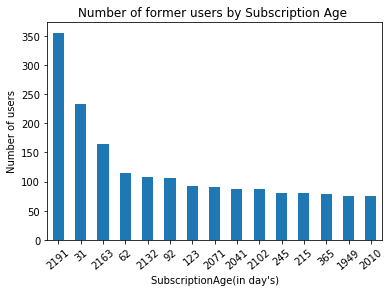

In [78]:
# Get only the largest 15 rows 
formerUsers_bySubscriptionAge.nlargest(15,'customerID').plot(kind='bar',rot=40, legend=None);
plt.xlabel('SubscriptionAge(in day\'s)')
plt.ylabel('Number of users')
plt.title('Number of former users by Subscription Age ')

- Most of the users are leaving after 31/30 day's and also after 61 day's.
- We need to pay special attention for new users and make sure they are not leaving after 30-60 day's. 

#### What kind of additional services former users used

In [79]:
# List of additional services
services = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [80]:
# Distribution by service
def plot_services(df):

    for service in services:
        df[service].value_counts().plot(kind='bar',rot=0);
        plt.xlabel(service)
        plt.ylabel('Number of users')
        plt.title('Number of former users by:' + service)
        plt.show()
 

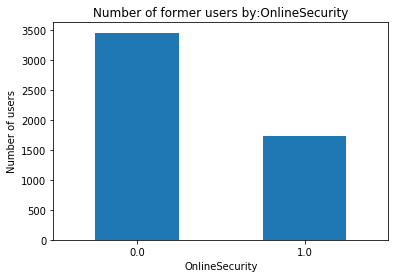

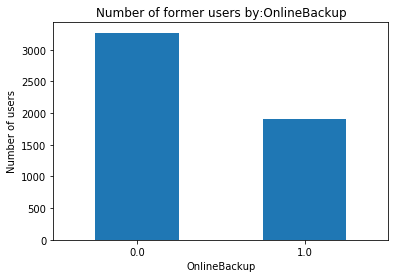

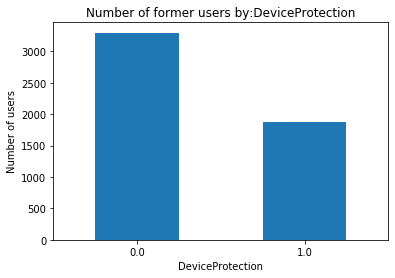

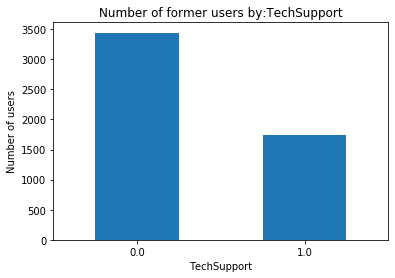

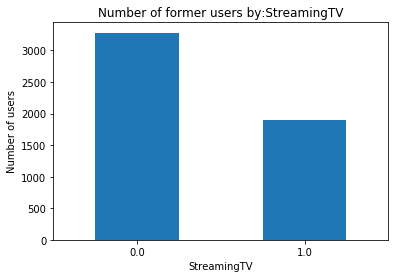

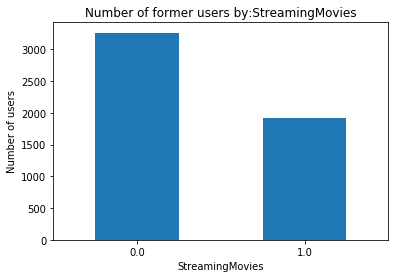

In [81]:
plot_services(former_users)

Churn rete for former users that had the following services is low:   
    - OnlineSecurity   
    - OnlineBackup   
    - DeviceProtection   
    - TechSupport   

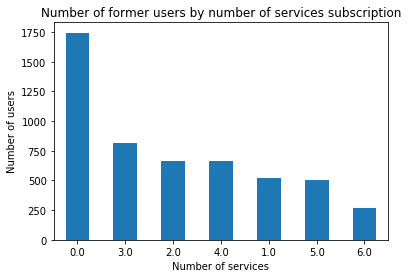

In [82]:
# Number of services former users had
former_users[services].sum(axis=1).value_counts().plot(kind='bar',rot=0);
plt.xlabel('Number of services')
plt.ylabel('Number of users')
plt.title('Number of former users by number of services subscription')
plt.show()

- More services former users had, churn rate  dropped.

#### What kind of additional services existing users are using

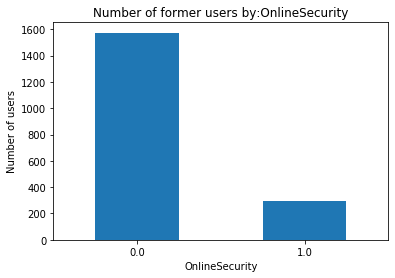

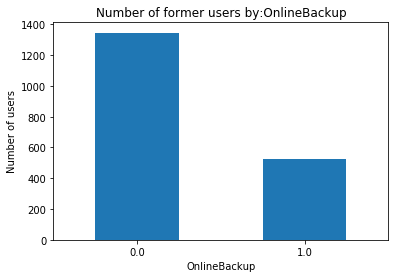

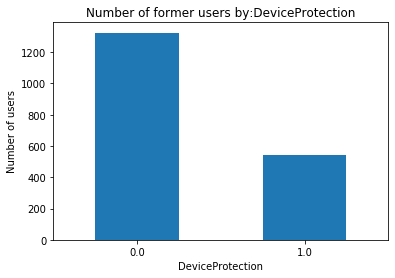

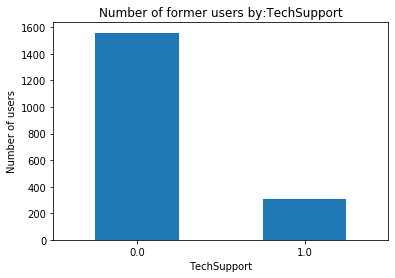

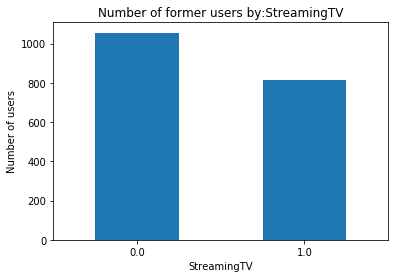

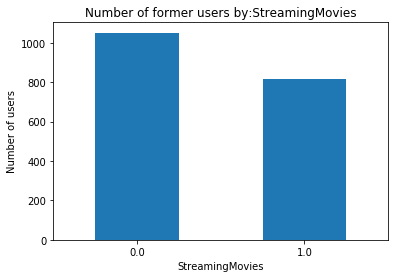

In [83]:
plot_services(existing_users)

- The majority of existing users are not using any additional services

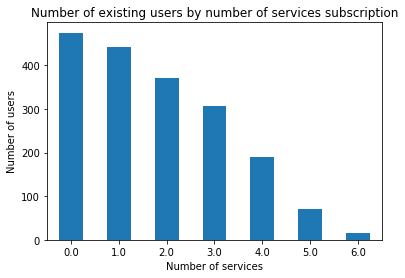

In [84]:
# Number of services existing users have
existing_users[services].sum(axis=1).value_counts().plot(kind='bar',rot=0);
plt.xlabel('Number of services')
plt.ylabel('Number of users')
plt.title('Number of existing users by number of services subscription')
plt.show()

- Most of the existing users are not using an additional services.

#### for existing/former users check the distribution of 'MultipleLines'

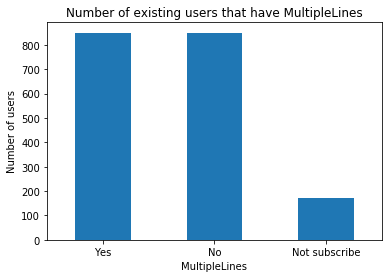

In [85]:
existing_users.MultipleLines.value_counts().plot(kind='bar',rot=0);
plt.xlabel('MultipleLines')
plt.ylabel('Number of users')
plt.title('Number of existing users that have MultipleLines')
plt.show()

- Existing users are using one line/multiple lines in almost the same distribution.

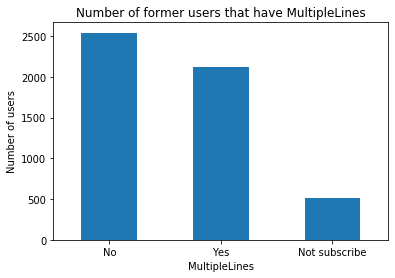

In [86]:
former_users.MultipleLines.value_counts().plot(kind='bar',rot=0);
plt.xlabel('MultipleLines')
plt.ylabel('Number of users')
plt.title('Number of former users that have MultipleLines')
plt.show()

former users used one line/multiple lines in same distribution.

#### for existing/former users check the distribution of 'InternetService'

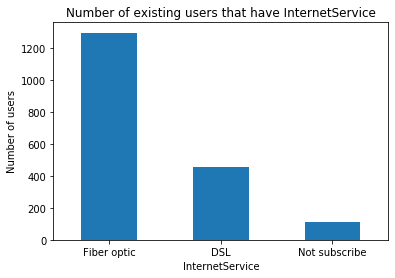

In [87]:
existing_users.InternetService.value_counts().plot(kind='bar',rot=0);
plt.xlabel('InternetService')
plt.ylabel('Number of users')
plt.title('Number of existing users that have InternetService')
plt.show()

- Existing users are using DSL/Fiber optic  in almost the same distribution.
- There are a lot of users that are not subscribe to internet service.

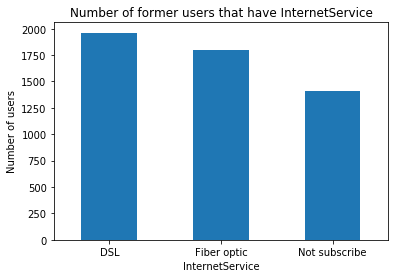

In [88]:
former_users.InternetService.value_counts().plot(kind='bar',rot=0);
plt.xlabel('InternetService')
plt.ylabel('Number of users')
plt.title('Number of former users that have InternetService')
plt.show()

- Most of the former users used Fiber optic internet service.
- There were few users that didn't subscribe to interner service.

#### Remove unnecessary features

In [89]:
#Drop feutures that are not necessary for model prediction
users = users.drop(columns=['BeginDate','customerID'],axis=1)

### Conclusions

- There are no outliers in the data.
- Most of the existing users are not using an additional services.     
- Existing users are using one line/multiple lines in almost the same distribution.     
- former users used one line/multiple lines in same distribution.   
- Existing users are using DSL/Fiber optic  in almost the same distribution.
- There are a lot of users that are not subscribe to internet service.
- Most of the former users used Fiber optic internet service.
- There were few users that didn't subscribe to interner service.
- Removed unnecessary features for prediction('BeginDate','customerID')

**Suggestments**
- The majority of former users had a 'Month-to-month' program.    
  The distribution for existing users is:    
     - 'Month-to-month' - 42.91%.   
     - 'Tow year' - 31.83%.   
     - 'One year' - 25.26%.         
  
  We can try to suggest different plan for users that discovered that they are planning to leave.
- Most of the users are leaving after 31/30 day's and also after 61 day's.     
  We need to pay special attention for new users and make sure they are not leaving after 30-60 day's.          
  This is the period of time to offer promotional codes and special plan options.

## Build the model

We have a binary classification problem.
- 'EndDate' ='No'= 1 for existing user
- 'EndDate' = 'Yes' = 0 for former user 

### Encoding the Categorical features

In [90]:
# Encode the Categorical features 
Categorical_features = ['Type','PaymentMethod','gender','InternetService','MultipleLines']
users = pd.get_dummies(users, drop_first=True)

In [91]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
EndDate                                  7043 non-null int8
PaperlessBilling                         7043 non-null int8
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
subscriptionAge                          7043 non-null int32
SeniorCitizen                            7043 non-null int8
Partner                                  7043 non-null int8
Dependents                               7043 non-null int8
OnlineSecurity                           7043 non-null float64
OnlineBackup                             7043 non-null float64
DeviceProtection                         7043 non-null float64
TechSupport                              7043 non-null float64
StreamingTV                              7043 non-null float64
StreamingMovies                          7043 non-null float64
Type_One year               

### Split the data to training set and test set

In [92]:
# Split data into train and test
target = users['EndDate']
features = users.drop(['EndDate'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE)


### Examine the balance of classes

In [93]:
users['EndDate'].value_counts()

1    5174
0    1869
Name: EndDate, dtype: int64

In [94]:
users['EndDate'].value_counts(normalize=True)

1    0.73463
0    0.26537
Name: EndDate, dtype: float64

Text(0.5, 1.0, 'EndDate Distribution')

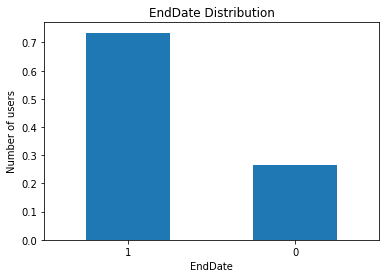

In [95]:
users['EndDate'].value_counts(normalize=True).plot(kind='bar',rot=0);
plt.xlabel('EndDate')
plt.ylabel('Number of users')
plt.title('EndDate Distribution')

We are dealing with imbalanced targer.    
There are 7043 observations:  
   - 5174 observations are with value 'No' (73%).   
   - 1869 observations are with value 'Yes' (27%).   
   
We will use 2 technique of data balancing:
1. Class Weight Adjustment
2. upsampling

### scaling the data

In [96]:
# Silence SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

# Standardize the numeric features
scaler = StandardScaler()

#numeric fields to scale
numeric = ['MonthlyCharges', 'TotalCharges','subscriptionAge']

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


### Train models

In [97]:
#The function contains the following steps:
# 1.train model
# 2.fit model
# 3.calc accuracy
# 4.calc roc_auc_score
# The function return a dataFrame contains:model name, accuracy score,roc_auc_score, best_estimator
def train_fit_score(model,X_train,y_train, params, modelName):
    model = GridSearchCV(model, param_grid=params, cv=5, refit='roc_auc',
                         verbose=0,scoring='roc_auc',return_train_score=True)
           
    model.fit(X_train, y_train) 
    
    # Predict the model      
    predict_test = model.predict(features_test)  
    
    # accuracy
    accuracy = accuracy_score(target_test,predict_test)
    # roc_auc score
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    roc_auc = roc_auc_score(target_test,probabilities_one_test)
   
    return  pd.DataFrame([[modelName,accuracy,roc_auc, model.best_estimator_]]\
                         ,columns=['model','accuracy','roc_auc','best_estimator_'])

####  RandomForest

In [ ]:
#Create Random Forest Classifier
params = {'n_estimators' : range(10, 120, 2),
          'max_depth' : range(5, 45, 10),
          'min_impurity_decrease' : np.arange(.05, .25, .1),
          'min_samples_split' : [3,5,7]
         
         }

RandomForest = train_fit_score(RandomForestClassifier(random_state=RANDOM_STATE,class_weight='balanced'),
                            features_train, 
                            target_train,
                            params, 
                            'Random Forest')
RandomForest

#### DecisionTree

In [ ]:
#Create Decision Tree Classifier
DecisionTree = train_fit_score(DecisionTreeClassifier(random_state=RANDOM_STATE,class_weight='balanced'), 
                      features_train,
                      target_train,
                      {'max_depth': range(1, 65, 5), 
                       'min_impurity_decrease' : np.arange(.01, .20, .02), 
                       'min_samples_split' : range(2, 10, 2)},
                       'Decision Tree')
DecisionTree

#### K-nearest Neighbors

In [ ]:
#Create KNeighborsClassifier 
KNNeighbors = train_fit_score(KNeighborsClassifier(), 
                        features_train, 
                        target_train,
                        {'n_neighbors' : range(40, 75, 5),
                         'weights' : ['uniform', 'distance'],
                         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size':range(20,40,5),
                         'p':[1,2]
                        },
                         'KNeighborsׁ')  
KNNeighbors

####  Logistic Regression

In [ ]:
# Create LogisticRegression model
lg = train_fit_score(LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE),
                    features_train, 
                    target_train,
                     {#'penalty':['l1', 'l2', 'elasticnet', 'none'],
                         #'multi_class':['auto', 'ovr', 'multinomial']
                       
                       'solver':['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                       'multi_class':['auto', 'ovr'],
                       'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                        'max_iter':[4000]
                     },
                     'Logistic Regression'
                    )
lg

#### Stochastic gradient descent

In [ ]:
#Create SGDClassifier 
sgd = train_fit_score(SGDClassifier(class_weight='balanced',random_state=RANDOM_STATE),
                        features_train, 
                        target_train,
                      {
                        'penalty':['l1', 'l2', 'elasticnet', 'none'],
                        'loss':['hinge','log','modified_huber','squared_hinge','perceptron'],
                        'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                        'max_iter':[4000]
                      },
                      'Stochastic gradient descent'
                     )
sgd

####  Naive Bayes

In [ ]:
#Create GaussianNB 
gnb = train_fit_score(GaussianNB(),
                        features_train, 
                        target_train,
                      {'var_smoothing': np.logspace(0,-9, num=100)},
                      'GaussianNB'
                      
                     )
gnb

#### catboost 

In [ ]:
#Create catboost 
catboost =  train_fit_score(CatBoostClassifier(),
                        features_train, 
                        target_train,
                         {'depth': [15],
                          'learning_rate' : [0.1],
                          'iterations'    : [15]
                         },
                          'CatBoost'                      
                      )
catboost

#### Sanity check

In [ ]:
#Use dummy model for a sanity check
dummy_model = train_fit_score(DummyClassifier(),
                                features_train, 
                                target_train,
                               {'strategy':['stratified', 'most_frequent', 'prior', 'uniform','constant'],
                               'constant':[1]},
                                'Dummy model'
                              )
dummy_model

####  Upsampling using pipline
Run all models using pipline and balance the data using SMOTE

In [ ]:
# List of estimators names
def get_Classifiers_Names():
    names = ['RandomForestClassifier',
         'DecisionTreeClassifier',
         'KNeighborsClassifier',
         'LogisticRegression',
         'SGDClassifier',
         'GaussianNB',
         'CatBoostClassifier',
        'DummyClassifier'
        ]

    return names


In [ ]:
# List of estimators
def get_Classifiers():

    classifiers = [
        RandomForestClassifier(random_state=RANDOM_STATE),
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        LogisticRegression(random_state=RANDOM_STATE),
        SGDClassifier(random_state=RANDOM_STATE),
        GaussianNB(),
        CatBoostClassifier(),
        DummyClassifier()
    ]
    return classifiers


In [ ]:
# Hyper parameters for each estimator
def get_Classifiers_params():
    parameters = [
                    {'n_estimators' : range(10, 120, 2),
                     'max_depth' : range(5, 45, 10),
                     'min_impurity_decrease' : np.arange(.05, .25, .1),
                     'min_samples_split' : [3,5,7]        
                     },

                    {'max_depth': range(1, 65, 5), 
                     'min_impurity_decrease' : np.arange(.01, .20, .02), 
                     'min_samples_split' : range(2, 10, 2)
                    },

                    {'n_neighbors' : range(40, 75, 5),
                     'weights' : ['uniform', 'distance'],
                     'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                     'leaf_size':range(20,40,5),
                     'p':[1,2] 
                    },    

                    { 'solver':['newton-cg', 'lbfgs', 'liblinear','sag','saga'],
                       'multi_class':['auto', 'ovr'],
                       'C' : [0.001, 0.01, 0.1, 1, 10, 100, 10001],
                        'max_iter':[4000]
                     },

                    {'penalty':['l1', 'l2', 'elasticnet', 'none'],
                     'loss':['hinge','log','modified_huber','squared_hinge','perceptron'],
                     'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'max_iter':[4000]
                    },

                    {'var_smoothing': np.logspace(0,-9, num=100)
                    },
        
                    {'depth': range(10, 60, 5),
                          'learning_rate' : np.arange(.05, .1, .01),
                          'iterations'    : range(10, 60, 5)
                    },
        
                    {'strategy':['stratified', 'most_frequent', 'prior', 'uniform','constant'],
                     'constant':[1]
                    }
                 ]
    return parameters  

In [ ]:
# Run all estemators 
for name, classifier, params in zip(get_Classifiers_Names(), get_Classifiers(), get_Classifiers_params()):
    #Create piprline
    imba_pipeline = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                                   (classifier)
                                 )
    #Modify params name to match pipeline format
    new_params = {name.lower() + '__' + key: params[key] for key in params}   

    # Run esimator
    globals()[f"{name}_upsampling"] = train_fit_score(imba_pipeline,
                         features_train,
                         target_train,
                         new_params,
                         name + 'upsampling'
                        )
    display(name+ '_upsampling')


####  Results

In [ ]:
# concat all models results
scores = pd.concat([RandomForest, DecisionTree,sgd,lg,KNNeighbors,gnb,catboost,\
                    RandomForestClassifier_upsampling,DecisionTreeClassifier_upsampling,SGDClassifier_upsampling,\
                    LogisticRegression_upsampling,KNeighborsClassifier_upsampling,GaussianNB_upsampling,\
                    CatBoostClassifier_upsampling,dummy_model,DummyClassifier ]).set_index('model')

scores[['accuracy','best_score_']] = scores[['accuracy','roc_auc']].round(2)
scores.drop(['best_estimator_'], axis=1,inplace=True)
display(scores.sort_values(by='roc_auc',ascending=False))

## Final model

catboost using Class Weight Adjustment for balance the data is the best model with 'roc_auc' = 86% on the train set

In [ ]:
catboost

In [99]:
catboost =  CatBoostClassifier(depth= 15,learning_rate = 0.1,iterations= 15)                                                                                   
catboost.fit(features_train, target_train)         
predict_test = catboost.predict(features_test)

# roc_auc calc
probabilities_test = catboost.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print(f'roc_auc score on test set:{roc_auc_score(target_test,probabilities_one_test).round(2)}')
print(f'accuracy score on test set:{accuracy_score(target_test,predict_test).round(2)}')                                       

0:	learn: 0.6217083	total: 2.25s	remaining: 31.5s
1:	learn: 0.5618153	total: 2.41s	remaining: 15.7s
2:	learn: 0.5195936	total: 2.51s	remaining: 10s
3:	learn: 0.4907276	total: 2.83s	remaining: 7.77s
4:	learn: 0.4680768	total: 2.83s	remaining: 5.67s
5:	learn: 0.4476962	total: 4.34s	remaining: 6.51s
6:	learn: 0.4306625	total: 6.01s	remaining: 6.87s
7:	learn: 0.4101154	total: 7.36s	remaining: 6.44s
8:	learn: 0.3886096	total: 8.89s	remaining: 5.93s
9:	learn: 0.3740869	total: 10.2s	remaining: 5.09s
10:	learn: 0.3595553	total: 11.5s	remaining: 4.18s
11:	learn: 0.3495004	total: 13s	remaining: 3.24s
12:	learn: 0.3401952	total: 14.3s	remaining: 2.2s
13:	learn: 0.3315859	total: 15.8s	remaining: 1.13s
14:	learn: 0.3239244	total: 17.1s	remaining: 0us
roc_auc score on test set:0.86
accuracy score on test set:0.82


## Conclusions
1. We have tried 2 different ways to balance the data:
    - Class Weight Adjustment.
    - Upsampling
2. catboost using Class Weight Adjustment for balance the data is the best model with 'roc_auc' = 86% and accuracy of 82%.
3. sanity check gave us a score of 50%.
4. All the models performed better than the sanity check.

**recomendation to marketing team**

1. The majority of former users had a 'Month-to-month' program.    
  The distribution for existing users is:    
     - 'Month-to-month' - 42.91%.   
     - 'Tow year' - 31.83%.   
     - 'One year' - 25.26%.         
  
  We can try to suggest different plan for users that discovered that they are planning to leave.
2. Most of the users are leaving after 31/30 day's and also after 61 day's.     
  We need to pay special attention for new users and make sure they are not leaving after 30-60 day's.          
  This is the period of time to offer promotional codes and special plan options.